<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задание" data-toc-modified-id="Задание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задание</a></span><ul class="toc-item"><li><span><a href="#Список-объектов" data-toc-modified-id="Список-объектов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Список объектов</a></span></li></ul></li><li><span><a href="#Данные-по-определенному-объекту" data-toc-modified-id="Данные-по-определенному-объекту-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Данные по определенному объекту</a></span></li><li><span><a href="#Сохранение-результатов" data-toc-modified-id="Сохранение-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сохранение результатов</a></span></li><li><span><a href="#Для-оптимизации-времени-используем-результат-предыдущего-задания" data-toc-modified-id="Для-оптимизации-времени-используем-результат-предыдущего-задания-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Для оптимизации времени используем результат предыдущего задания</a></span></li><li><span><a href="#Удаление-неинформативных-столбцов" data-toc-modified-id="Удаление-неинформативных-столбцов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Удаление неинформативных столбцов</a></span></li></ul></div>

# Задание
* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить результаты в pandas dataframe
<hr>

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
-- Привести колонки датафрейма к одному типу данных
-- Проверить индекс, чтобы он соответствовал порядку строк
-- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки
<hr>

* Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.
-- Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены.
-- Рассчитать объемы вводимого жилья по регионам и по годам.
-- Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах
-- Визуализировать разброс, связь и распределение этих показателей по регионам
-- Сделать выводы по каждому из расчетов и графиков

In [1]:
# Импорт библиотек
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from turtle import title
#from sqlalchemy import create_engine

In [2]:
# Ограничение вывода строк на экран
pd.options.display.max_rows = 120

## Список объектов

In [ ]:
# Для скачивания данных по блоками по 100
# Задание параметров: начальное смещение равно 1, количество записей в блоке равно 100
offset_ = 0
limit_ = 100
# Пустой список ID объектов
objids = []
# Цикл из 1 млн итераций по 100 объектов (до 100млн домой, на сайте их 10583)
for i in range(1000000):
# Выполняем запрос к сайту, выдергиваем json
    try:
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        res = requests.get(url)
        objects_data = res.json()
# Проверяем, есть ли в ответе объект
        objects_data.get('data').get('list')[0]
# Объекта нет - прерываем цикл
    except IndexError:
#        print('прерывание')
        break
# Не возникло исключение - берем ID объектов и добавляем их в список objids
    else:
        objects_list = objects_data.get('data').get('list')
        objids.extend([x.get('objId') for x in objects_list])
# увеличиваем смещение на 100
        offset_ += 100

In [ ]:
# Определяем количество строящихся объектов на сайте
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=0&limit=10&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
res = requests.get(url)
total = res.json().get('data').get('total')

# Задание параметров: начальное смещение равно 1, количество записей в блоке равно 100
offset_ = 0
limit_ = 100
# Пустой список ID объектов
objids = []
# Цикл выполняется, пока смещение не превысит общее количество объектов
while offset_ <= total:
# Выполняем запрос к сайту, выдергиваем json
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
# Берем ID объектов и добавляем их в список objids
    objects_list = res.json().get('data').get('list')
    objids.extend([x.get('objId') for x in objects_list])
# увеличиваем смещение на 100
    offset_ += 100

# Данные по определенному объекту

In [ ]:
# Для скачивания данных по определенному объекту, нужно добавить его id в конец строки запроса
res_full = []
# Для каждого объекта в списке objids
for ID_obj in tqdm(objids):
# Получение информации
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{ID_obj}'
    res = requests.get(url)
# Добавление в итоговый список
    res_full.append(res.json().get('data'))
# СОздание датафрейма
df = pd.json_normalize(res_full)
df

# Сохранение результатов

In [ ]:
# Сохранение результатов в excel
df.to_excel("ndrf_df.xlsx", encoding='cp1251')

In [ ]:
# Сохранение результатов в pickle
df.to_pickle("ndrf_df.pkl")

In [ ]:
# Создание базы данных SQLite
con = sqlite3.connect("ndrf_df.db")

# Приведение датафрейма к строковому типу (иначе SQL ругается)
df = df.astype('str')

# Сохранение датафрейма в таблицу buildings
df.to_sql("buildings", con, if_exists="replace", index=False)
con.commit()
con.close()


In [6]:
# Открываем базу данных SQLite
con = sqlite3.connect("ndrf_df.db")

# Проверка того, как данные выгрузились в БД
df1 = pd.read_sql("SELECT * FROM buildings", con)
con.commit()
con.close()

df1

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,developer.bankruptStage.bankruptStageDesc,developer.bankruptStage.bankruptLawUrl,developer.orgBankruptMsgDttm,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors
0,29679,124647,61,г Таганрог,18,2020-03-31,Другое,Под ключ,Есть,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,13398,28141,72,"г Тюмень, ул Профсоюзная, д. 56",43,2024-12-31,Другое,Без отделки,Нет,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10580,28072,96379,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",312,2024-06-30,Другое,Под ключ,Нет,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10581,28071,99284,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",288,2024-06-30,Другое,Под ключ,Нет,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10582,28073,96446,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",312,2024-06-30,Другое,Под ключ,Нет,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10583,44447,475093,76,"г Ярославль, Фрунзенский район, территория в р...",127,2022-12-31,Кирпич,Другое,Нет,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


# Для оптимизации времени используем результат предыдущего задания

In [616]:
# Импорт датафрейма из файла, полученного в результате выполнения 1 задания
df = pd.read_pickle('ndrf_df.pkl')
df.shape

(10585, 108)

# Предварительная обработка данных

In [617]:
# Индекс соответствует порядку строк
df.index

RangeIndex(start=0, stop=10585, step=1)

In [618]:
# Есть столбец objPriceAvg, который характеризует среднюю цену за квадратный метр
# Удаляем строки, в которых средняя цена за квадратный метр отсутствует
df = df[df.objPriceAvg.notnull()]
df.shape

(7729, 108)

In [619]:
# Смотрим столбцы, в которых более 90% пропущенных значений
col_nul_sum = df.isnull().sum(axis=0)
col_nul_sum[col_nul_sum.values > 0.9*len(df)]

complexShortNm                               7025
developer.bankruptStage.bankruptStageCd      7682
developer.bankruptStage.bankruptStageDesc    7682
developer.bankruptStage.bankruptLawUrl       7682
developer.orgBankruptMsgDttm                 7682
metro.id                                     7728
metro.name                                   7728
metro.line                                   7728
metro.color                                  7728
metro.time                                   7728
metro.isWalk                                 7728
metro.colors                                 7728
dtype: int64

In [620]:
# Специфичных для регионов столбцов нет - их можно удалить
df.dropna(thresh=(0.1*len(df)), axis=1, inplace=True)
df.head(3)

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN
3,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [621]:
# Найдем столбцы с 1 значением
for i in df.columns:
    if df[i].value_counts().count() == 1:
        print(df[i].value_counts())

0    7729
Name: objProblemFlg, dtype: int64
12-09-2022 01:26    7729
Name: loadDttm, dtype: int64
normal    7729
Name: objectType, dtype: int64
0    7729
Name: objStatus, dtype: int64


In [622]:
# Удалим эти столбцы
for i in df.columns:
    if df[i].value_counts().count() == 1:
        del df[i]
df.head(3)

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN
3,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [623]:
# Посмотрим на столбцы которые остались
df.head().T

,1,2,3,4,5
id,13383,13397,13399,13398,13391
pdId,28105,28141,28141,28141,28101
region,72,72,72,72,72
address,г Тюмень,"г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная"
objElemLivingCnt,68,65,0,43,44
objReady100PercDt,2022-12-31,2024-12-31,2024-12-31,2024-12-31,2022-12-31
wallMaterialShortDesc,Другое,Другое,Другое,Другое,Другое
objLkFinishTypeDesc,По желанию заказчика,Без отделки,Без отделки,Без отделки,По желанию заказчика
objLkFreePlanDesc,Есть,Нет,Нет,Нет,Есть
objElemParkingCnt,31,0,125,0,41


In [633]:
# контрольная точка
#df1 = df.copy()
df = df1.copy()
df.head(3)

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN
3,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [634]:
# Удалим неинформативные столбцы
del df['id']                                # ID объекта на портале
del df['pdId']                              # ID проекта на портале
del df['rpdNum']                            #  № проекта
del df['rpdPdfLink']                        # ссылка на проектную документацию
del df['rpdIssueDttm']                      # Выпуск проектной документации
del df['objLkLatitude']                     # Координаты дома
del df['objLkLongitude']                    # Координаты дома
del df['photoRenderDTO']                    # Фотографии
del df['newBuildingId']                     # ID здания
del df['objFlatSq']                         # площадь квартир соответствует жилой площади
del df['objectTransportInfo']               # почти везде пустой список
del df['floorMin']                          # Минимальный этаж
del df['floorMax']                          # Максимальный этаж
del df['miniUrl']                           # URL
del df['objTransferPlanDt']                 # Дата выдачи ключей - не берем, так как есть дата ввода в эксплуатацию
del df['developer.devId']                   # Информация о застройщике
del df['developer.devShortNm']              # Информация о застройщике
del df['developer.devFullCleanNm']          # Информация о застройщике
del df['developer.buildObjCnt']             # Информация о застройщике
del df['developer.comissObjCnt']            # Информация о застройщике
del df['developer.regRegionDesc']           # Информация о застройщике
del df['developer.devPhoneNum']             # Информация о застройщике
del df['developer.devSite']                 # Информация о застройщике
del df['developer.devEmail']                # Информация о застройщике
del df['developer.devInn']                  # Информация о застройщике
del df['developer.devOgrn']                 # Информация о застройщике
del df['developer.devKpp']                  # Информация о застройщике
del df['developer.devLegalAddr']            # Информация о застройщике
del df['developer.devFactAddr']             # Информация о застройщике
del df['developer.lastRpdId']               # Информация о застройщике
del df['developer.devOrgRegRegionCd']       # Информация о застройщике
del df['developer.devEmplMainFullNm']       # Информация о застройщике
del df['developer.orgForm.id']              # Информация о застройщике
del df['developer.orgForm.fullForm']        # Информация о застройщике
del df['developer.orgForm.shortForm']       # Информация о застройщике
del df['generalContractorNm']
del df['objLkSaleDepEmail']                 # Информация о застройщике
del df['developer.companyGroupId']          # Информация о застройщике
del df['transportDistIndex']                # дублирует transportDistIndexValue
del df['nameObj']                           # имя объекта
df.head()

,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,...,quartography.objLivElem1KCnt,quartography.objLivElem2KCnt,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndexValue,greenAreaIndexValue,airQualityIndexValue
1,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,6293.78,1,...,13.0,21.0,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN
2,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,6248.51,0,...,0.0,24.0,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN
3,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,0.00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72,"г Тюмень, ул Профсоюзная, д. 56",43,2024-12-31,Другое,Без отделки,Нет,0,4812.98,0,...,0.0,11.0,19.0,13.0,43.0,3.0,3.0,NaN,NaN,NaN
5,72,"г Тюмень, ул Профсоюзная",44,2022-12-31,Другое,По желанию заказчика,Есть,41,4297.44,1,...,11.0,16.0,12.0,5.0,44.0,2.0,4.0,NaN,NaN,NaN


del df['id']# Сохранение результатов

In [635]:
# Оставшиеся столбцы
df.head().T

,1,2,3,4,5
region,72,72,72,72,72
address,г Тюмень,"г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная, д. 56","г Тюмень, ул Профсоюзная"
objElemLivingCnt,68,65,0,43,44
objReady100PercDt,2022-12-31,2024-12-31,2024-12-31,2024-12-31,2022-12-31
wallMaterialShortDesc,Другое,Другое,Другое,Другое,Другое
objLkFinishTypeDesc,По желанию заказчика,Без отделки,Без отделки,Без отделки,По желанию заказчика
objLkFreePlanDesc,Есть,Нет,Нет,Нет,Есть
objElemParkingCnt,31,0,125,0,41
objSquareLiving,6293.78,6248.51,0.0,4812.98,4297.44
objCompensFundFlg,1,0,0,0,1


In [636]:
# Добавим столбец с годом ввода в эксплуатацию
df.insert(1, 'year_expl', df.objReady100PercDt.str.split('-', expand = True)[0])

# Приведем год ввода в эксплуатацию к числовому типу
df.year_expl = df.year_expl.astype('int')
df.year_expl.dtype

# Дату сдачи можно удалить
del df['objReady100PercDt']

df.year_expl.dtype

dtype('int32')

In [637]:
# Добавим столбец с городом
df.insert(1, 'city', df.address.str.split(',', expand = True)[0])

# Адрес можно удалить
del df['address']

df.head(3)

,region,city,year_expl,objElemLivingCnt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,objCompensFundFlg,...,quartography.objLivElem1KCnt,quartography.objLivElem2KCnt,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndexValue,greenAreaIndexValue,airQualityIndexValue
1,72,г Тюмень,2022,68,Другое,По желанию заказчика,Есть,31,6293.78,1,...,13.0,21.0,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN
2,72,г Тюмень,2024,65,Другое,Без отделки,Нет,0,6248.51,0,...,0.0,24.0,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN
3,72,г Тюмень,2024,0,Другое,Без отделки,Нет,125,0.00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [638]:
# Регион приводим к строковому типу
df.region = df.region.astype('str')
df.region.dtype

dtype('O')

# Сбор информации по вводу жилья и ценам по регионам

In [639]:
# Посчитаем площадь вводимого жилья по регионам и годам

# Создадим датафрейм с колонками регион, год ввода в эксплуатацию, жилая площадь объекта для построения диаграмм
df_expl_region = df[['region', 'year_expl', 'objSquareLiving']].copy()

# Удалим строки с пустыми значениями
df_expl_region.dropna(inplace=True)

# Рассчитаем вводимую в эксплуатацию площаль по регионам по годам
df_expl_region_gr = df_expl_region.groupby(['region','year_expl'])['objSquareLiving']
df_expl_region['all_square'] = df_expl_region_gr.transform(sum)
del df_expl_region['objSquareLiving']
df_expl_region.drop_duplicates(inplace=True)

# Удалим строки с пустой общей площадью
df_expl_region = df_expl_region[df_expl_region.all_square > 0]
df_expl_region.head(3)

,region,year_expl,all_square
1,72,2022,484424.60
2,72,2024,416902.36
6,26,2022,120540.88


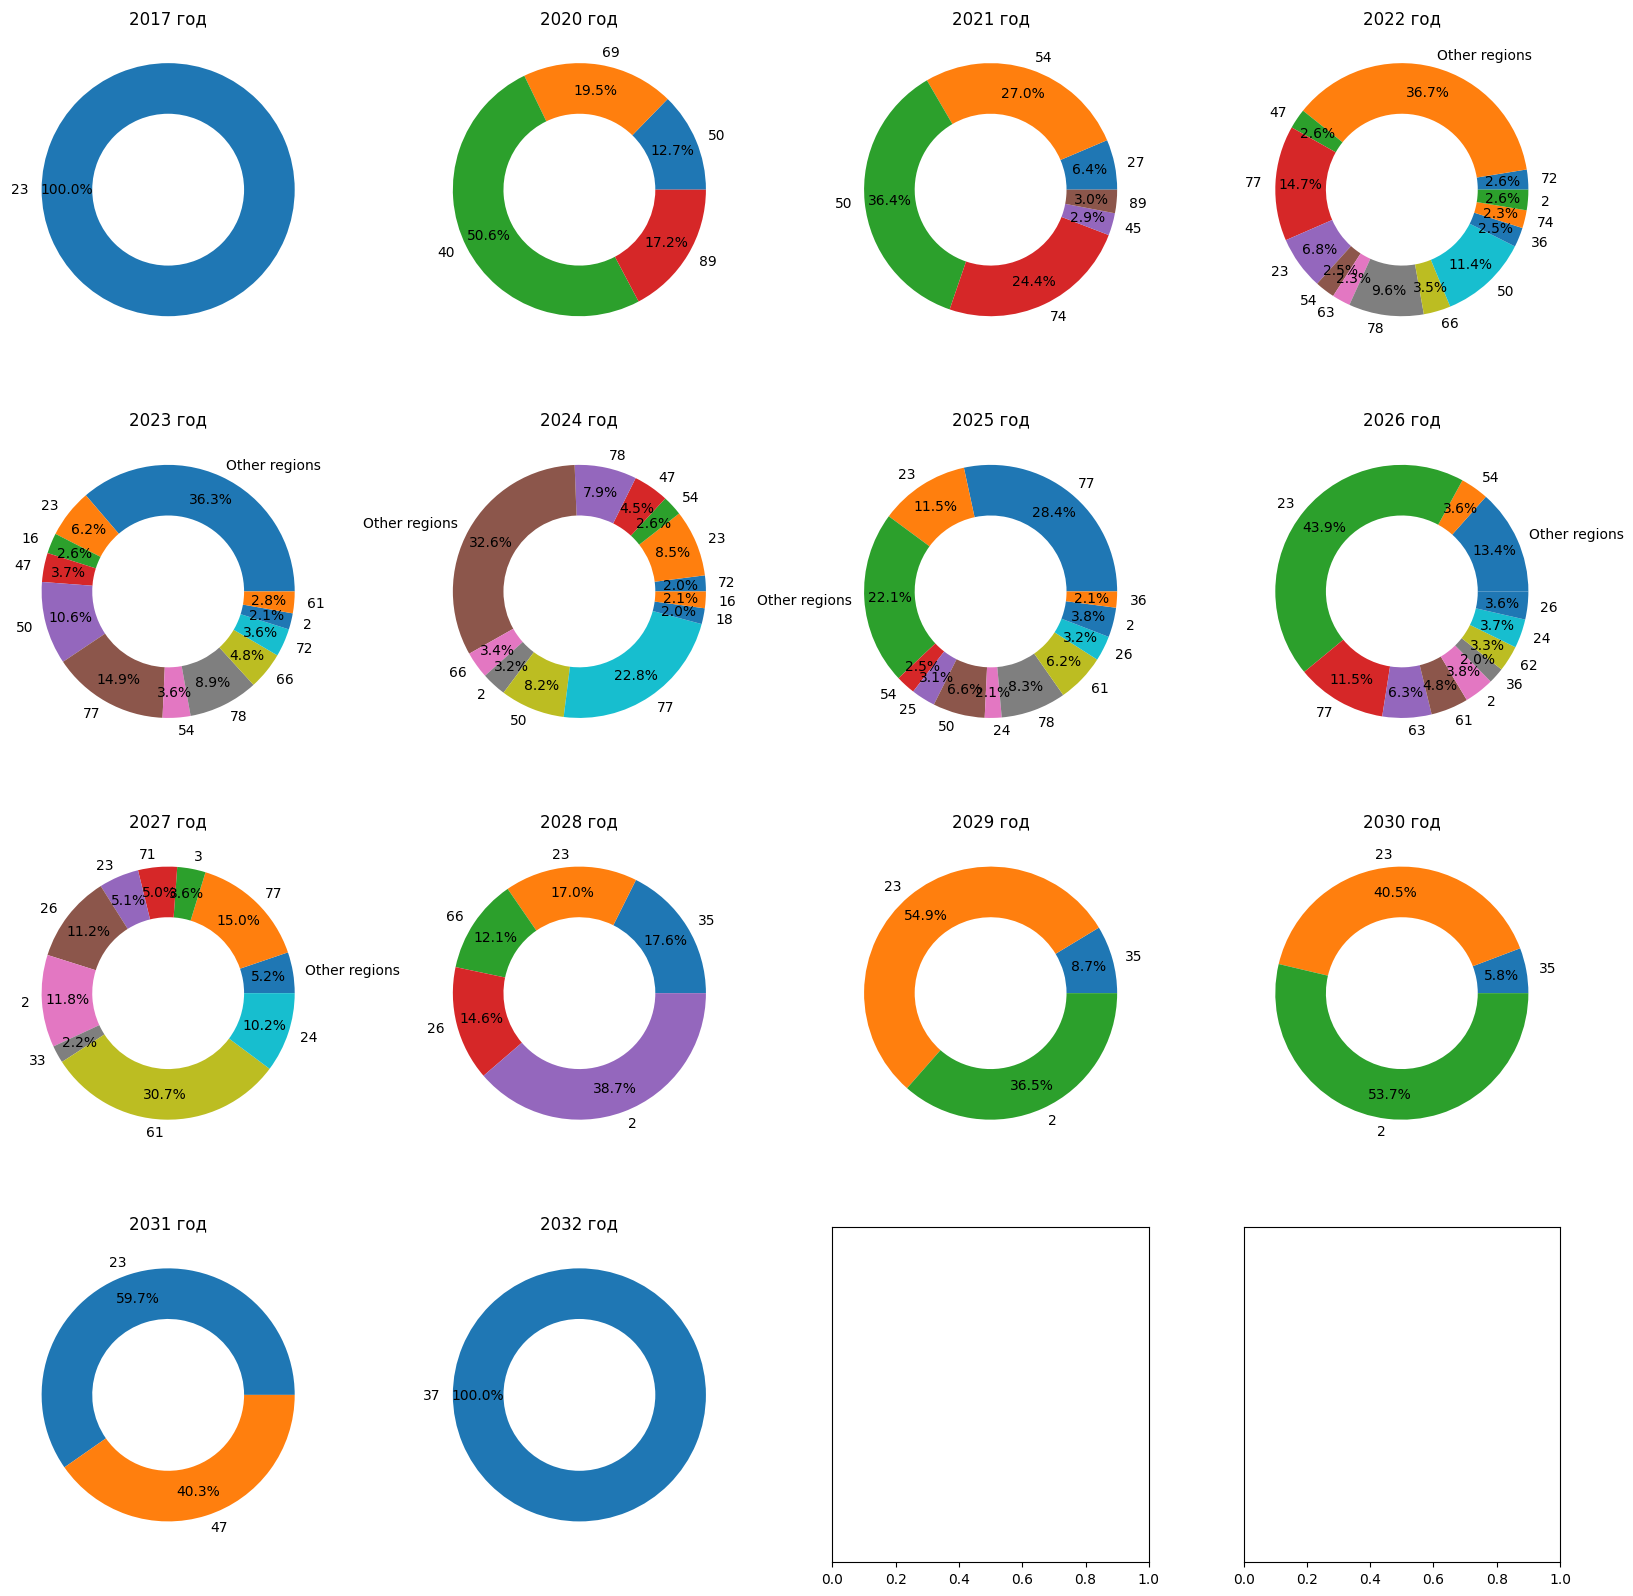

In [640]:
# Построим круговые диаграммы (бублики) по годам

# Список уникальных годов
list_years = df_expl_region.year_expl.unique()
list_years.sort()

# количество графиков по ширине
ncol = int(len(list_years)/4 + 1)

# Строим графики
fig, ax = plt.subplots(nrows=4,ncols=ncol, sharey=True)
for i in range(len(list_years)):
    df_expl_region_1 = df_expl_region[df_expl_region.year_expl == list_years[i]].copy()
    
    # Регионы с малым процентом вводимого жилья группируем в Other regions
    df_expl_region_1.loc[df_expl_region_1['all_square'] < (df_expl_region_1['all_square'].sum()) * 0.02, 'region'] = 'Other regions' # Represent only large countries
    df_expl_region_1_gr = df_expl_region_1.groupby(['region','year_expl'])['all_square']
    df_expl_region_1['all_square'] = df_expl_region_1_gr.transform(sum)
    df_expl_region_1.drop_duplicates(inplace=True)   

    v1 = df_expl_region_1['all_square']
    labels1 = df_expl_region_1['region']
    width = 0.4
    wedge_properties = {"width":width}
    ax[i//ncol,i%ncol].pie(v1,
                           labels=labels1,
                           wedgeprops=wedge_properties,
                           autopct="%1.1f%%", pctdistance=0.8)
    ax[i//ncol,i%ncol].set_title(str(list_years[i]) + ' год')
fig.set_size_inches(20,20)
plt.subplots_adjust(wspace=0.3 )

# Так как масштаб графиков небольшой, можно наблюдать общие тенденции: в 2022 - 2025 годах большая доля жилья вводится в эксплуатацию в Москве

In [758]:
# Функция построения круговой диаграммы ввода жилья в эксплуатацию по регионам в зависимости от года
def region_square(year):
    df_expl_region_2 = df_expl_region[df_expl_region.year_expl == year].copy()
    # Регионы с вводом жилья менее 0.5% по стране группируем в Other regions для удобства восприятия графика
    df_expl_region_2.loc[df_expl_region_2['all_square'] < (df_expl_region_2.all_square.sum() * 0.005), 'region'] = 'Other regions'
    fig = px.pie(df_expl_region_2, values='all_square', names='region', width=1200, height=1000, title=(str(year) + ' год'))
   # fig.set_size_inches(20,20)
    fig.show()

In [759]:
# На вход подаем год, за который нужен график
region_square(2024)

In [643]:
# Посчитаем площадь вводимого жилья по регионам, городам и годам

# Создадим датафрейм с колонками регион, город, год ввода в эксплуатацию, жилая площадь объекта для построения диаграммы sunburst
df_expl_city = df[['region', 'city', 'year_expl', 'objSquareLiving']].copy()

# Удалим строки с пустыми значениями
df_expl_city.dropna(inplace=True)

# Рассчитаем вводимую в эксплуатацию площаль по городам по годам
df_expl_city_gr = df_expl_city.groupby(['region','city','year_expl'])['objSquareLiving']
df_expl_city['all_square'] = df_expl_city_gr.transform(sum)
del df_expl_city['objSquareLiving']
df_expl_city.drop_duplicates(inplace=True)

# Удалим строки с пустой общей площадью
df_expl_city = df_expl_city[df_expl_city.all_square > 0]
df_expl_city.head(3)


,region,city,year_expl,all_square
1,72,г Тюмень,2022,262296.37
2,72,г Тюмень,2024,351144.12
6,26,г Ставрополь,2022,63983.15


In [745]:
# Функция построения круговой диаграммы ввода жилья в эксплуатацию по годам
def region_city_square(year):
    df_expl_city_1 = df_expl_city[df_expl_city.year_expl == year]
    fig = px.sunburst(df_expl_city_1, path=['region', 'city'], values='all_square',color='all_square', hover_data=['all_square'], title=year, width=1000, height=1000)
    fig.show()

In [761]:
# Строим график по нужному году
# Вывод: в Москве с дальним сроком ввода в эксплуатацию жилья не так много, быстро строют; в 2025-2027 много жилья строится на юге
region_city_square(2026)


In [732]:
# Посчитаем среднюю цену жилья по регионам

# Копия датафрейма для работы
df_region_avg = df[['region','objSquareLiving', 'objPriceAvg']].copy()

# Удалим строки с пустыми значениями
df_region_avg.dropna(inplace=True)

# Считаем стоимость всей площади объекта
df_region_avg['objPrice'] = df_region_avg.apply(lambda r: r.objSquareLiving * r.objPriceAvg, axis=1)

# Группируем датафрейм по региону, нужны столбцы objSquareLiving и objPrice
df_region_avg_gr = df_region_avg.groupby(['region'])[['objSquareLiving', 'objPrice']]
# Считаем суммы по стоимости всего жилья и всей площади
df_region_avg = df_region_avg_gr.agg([('sum', 'sum')])

# Считаем отношение стоимости всего жилья в регионе к площади всего жилья в регионе
df_region_avg['avg_price'] = df_region_avg.apply(lambda x: x.objPrice / x.objSquareLiving, axis=1)

# Оставляем для региона только столбец со средней ценой жилья
df_region_avg = df_region_avg.avg_price

# Округляем среднюю стоимость жилья до целого
df_region_avg = df_region_avg.astype('int')
df_region_avg = df_region_avg.sort_values(ascending=False)
df_region_avg = df_region_avg.reset_index()
df_region_avg.head()

,region,avg_price
0,77,292299
1,78,189030
2,65,148033
3,50,135181
4,92,130431


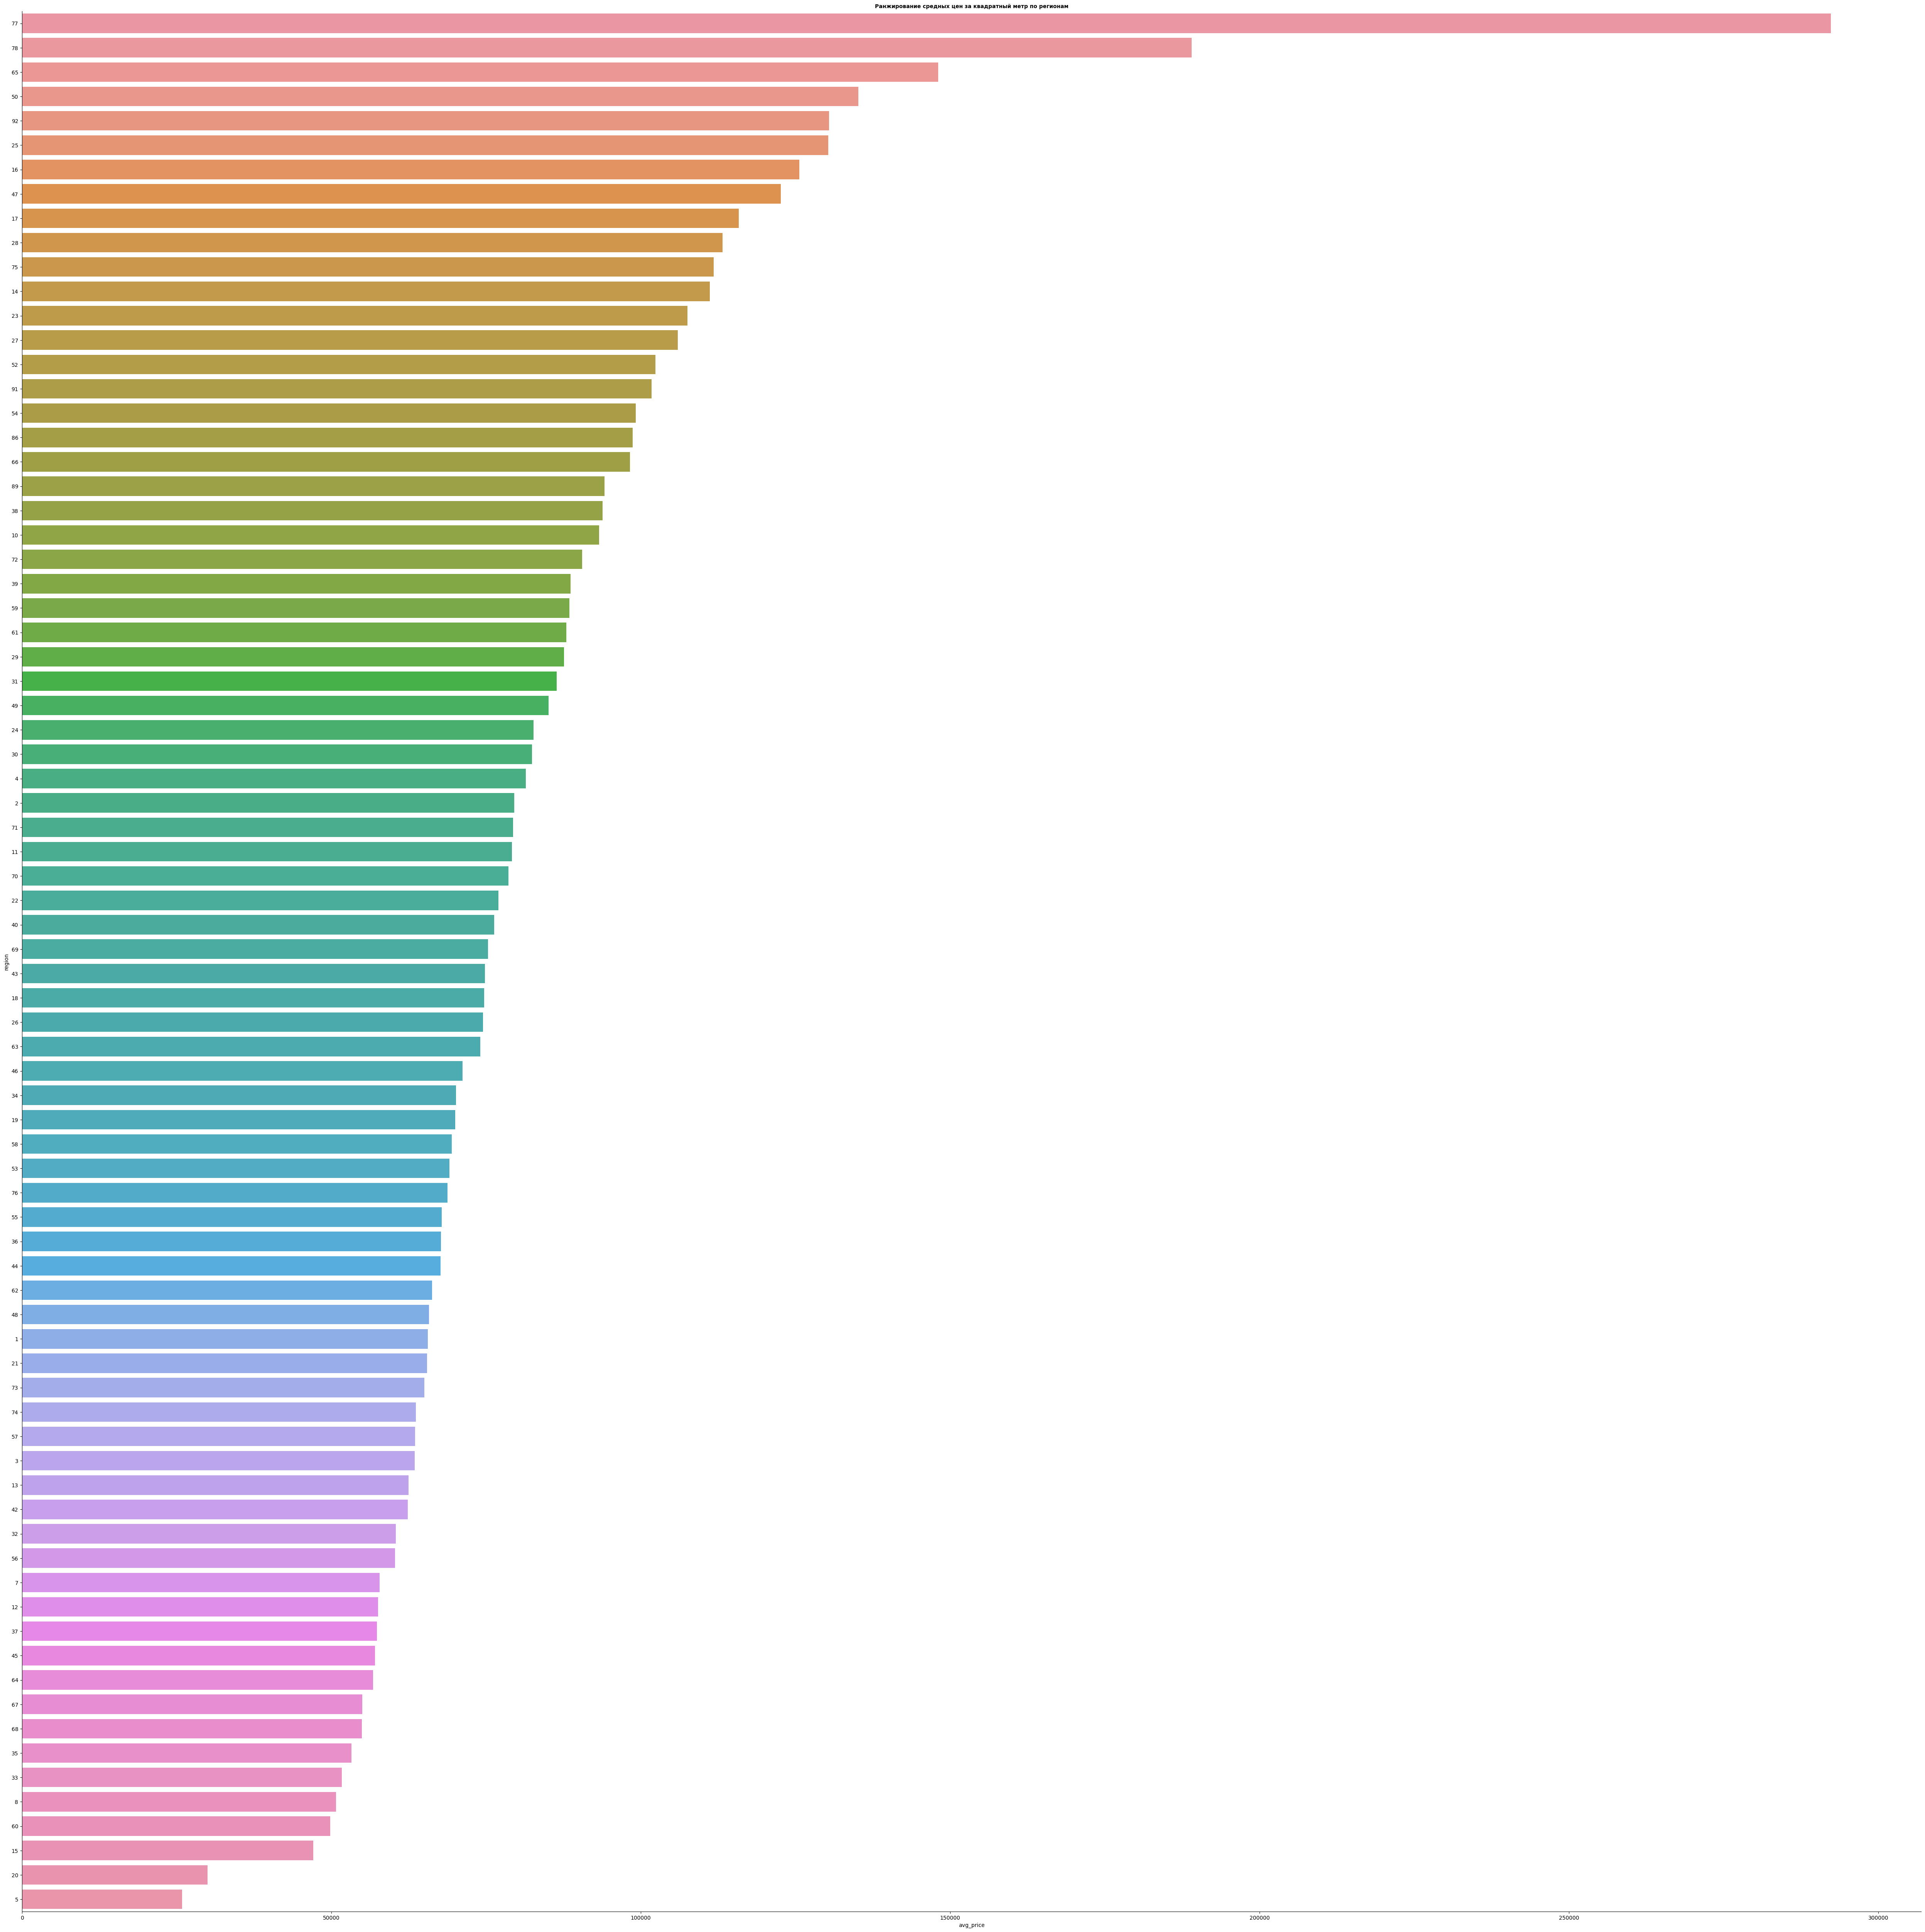

In [772]:
# Построим график Count Plot

sns.catplot(
    x='avg_price', 
    y='region', 
    data=df_region_avg, 
    kind='bar', 
    capsize=0.2, 
    height=50, 
    aspect=1); 

plt.title('Ранжирование средных цен за квадратный метр по регионам',
          size=10, 
          color='k', 
          weight='bold');

In [741]:
# Столбиковая диаграмма
fig = px.bar(df_region_avg, x="avg_price", y="region", width=1200, height=1600)

fig.show()

In [646]:
# Посмотрим встречаемость значений столбцов в процентах
for i in df.columns:
    print(df[i].value_counts(normalize=True))

23    0.087333
77    0.087204
50    0.078018
78    0.061716
54    0.038944
66    0.032863
47    0.030664
72    0.027170
61    0.025877
2     0.024971
16    0.024842
25    0.021607
91    0.020701
39    0.020701
63    0.017208
38    0.017079
74    0.015655
24    0.015526
36    0.015267
52    0.014879
26    0.014491
18    0.014361
59    0.013844
35    0.012291
33    0.011644
34    0.011515
27    0.010351
71    0.009962
58    0.009962
22    0.009704
42    0.009574
76    0.009186
21    0.007892
73    0.007763
40    0.007634
62    0.007375
29    0.007375
67    0.007245
69    0.007116
44    0.006728
32    0.005952
31    0.005822
64    0.005693
55    0.005305
12    0.005175
86    0.005175
43    0.004917
56    0.004917
14    0.004917
65    0.004787
3     0.004658
37    0.004658
1     0.004399
15    0.004270
68    0.004011
48    0.004011
45    0.004011
46    0.003752
57    0.003752
30    0.003752
60    0.003493
19    0.003235
28    0.003105
89    0.002846
92    0.002846
10    0.002588
70    0.00

# Исследование строящегося жилья в Москве

In [614]:
# Ограничиваем датафрейм объектами в Московском регионе
df_Moscow = df[df.region == '32'].copy()
df_Moscow.head(100)

,region,address,objElemLivingCnt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,objSquareLiving,rpdNum,objCompensFundFlg,...,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue,year_expl,city
1209,32,"г Брянск, район Бежицкий, улица Ново-Советская...",108,Кирпич,Без отделки,Нет,0,6116.65,32-000373,0,...,108.0,1.0,9.0,NaN,NaN,ЖК «Мечта»,NaN,NaN,2022,г Брянск
1210,32,"г Брянск, район Бежицкий, улица Ново-Советская...",202,Кирпич,Без отделки,Нет,0,10893.90,32-000370,0,...,202.0,2.0,8.0,NaN,NaN,ЖК «Мечта»,NaN,NaN,2022,г Брянск
1437,32,"п Мичуринский, корпус 2, строение 4,5",261,Кирпич,Другое,Нет,0,16364.25,32-000268,1,...,261.0,16.0,4.0,NaN,NaN,NaN,NaN,NaN,2022,п Мичуринский
2477,32,г Брянск,381,Монолит-кирпич,Под чистовую,Нет,0,21120.41,32-000318,0,...,381.0,3.0,9.0,NaN,NaN,"Жилой комплекс ""Атмосфера в Парке""",NaN,NaN,2024,г Брянск
2479,32,г Брянск,233,Кирпич,Под чистовую,Нет,0,14679.42,32-000306,0,...,233.0,4.0,7.0,NaN,NaN,"Жилой комплекс""Атмосфера в Парке""",NaN,NaN,2024,г Брянск
2480,32,"г Брянск, ул Ульянова",383,Кирпич,Под чистовую,Нет,0,18622.60,32-000355,0,...,383.0,4.0,11.0,NaN,NaN,Авторский квартал Романовский,NaN,NaN,2025,г Брянск
2481,32,"г Брянск, Территория бывшего аэропорта",182,Кирпич,Под чистовую,Нет,0,12289.68,32-000292,0,...,182.0,2.0,7.0,NaN,NaN,"Жилой комплекс""Атмосфера в Центре""",NaN,NaN,2023,г Брянск
2715,32,"г Брянск, ул им. О.С. Визнюка, д. 8",108,Другое,Без отделки,Нет,0,4876.02,32-000320,0,...,108.0,2.0,6.0,NaN,NaN,"Жилой Комплекс ""Видный""",NaN,NaN,2022,г Брянск
2716,32,"г Брянск, район Бежицкий, улица Флотская, д. 1...",160,Другое,Без отделки,Нет,0,10655.40,32-000278,0,...,160.0,4.0,4.0,NaN,NaN,"Микрорайон ""Деснаград""",NaN,NaN,2023,г Брянск
2717,32,"г Брянск, ул им. О.С. Визнюка, д. 10",108,Другое,Без отделки,Нет,0,4876.02,32-000335,0,...,108.0,2.0,6.0,NaN,NaN,"Жилой Комплекс ""Видный""",NaN,NaN,2022,г Брянск


In [609]:
# Смотрим на столбцы еще раз
df_Moscow.head().T

,9,28,39,40,308
region,77,77,77,77,77
address,"п Коммунарка, д. 17, корпус 4","г Москва, улица Адмирала Макарова, корпус 6, в...","г Москва, район Левобережный, шоссе Ленинградс...","г Москва, район Левобережный, ш Ленинградское,...","г Москва, проезд Береговой, корпус 1, вл. 2Б"
objElemLivingCnt,99,396,204,0,782
wallMaterialShortDesc,Монолит-кирпич,Другое,Монолит-кирпич,Монолит-кирпич,Монолит-кирпич
objLkFinishTypeDesc,Без отделки,Без отделки,Под ключ,Под ключ,Другое
objLkFreePlanDesc,Нет,Есть,Нет,Нет,Нет
objElemParkingCnt,0,0,36,389,558
objSquareLiving,5589.5,20225.0,16726.99,0.0,68693.8
rpdNum,77-001702,77-001165,77-001401,77-002435,77-002000
objCompensFundFlg,0,1,1,0,0


In [615]:
# Удаляем ненужные столбцы
'''del df_Moscow['region']
del df_Moscow['']



'''

1209     []
1210     []
1437     []
2477     []
2479     []
2480     []
2481     []
2715     []
2716     []
2717     []
2718     []
2719     []
2975     []
3321     []
3632     []
3633     []
3634     []
3635     []
3876     []
3877     []
4230     []
4235     []
4237     []
4444     []
4445     []
4632     []
4634     []
5163     []
5164     []
5165     []
5166     []
5167     []
5168     []
5169     []
5171     []
5172     []
6540     []
6673     []
7303     []
7309     []
7573     []
7653     []
7654     []
8236     []
9786     []
10584    []
Name: objectTransportInfo, dtype: object

In [120]:
# Сохранение промежуточный результатов в excel
df.to_excel("ndrf_df_clear.xlsx", encoding='cp1251')

C:\Users\User\AppData\Local\Temp\ipykernel_11140\2281941785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.region = df.region.astype('str')


str

0    7729
Name: objProblemFlg, dtype: int64
12-09-2022 01:26    7729
Name: loadDttm, dtype: int64
normal    7729
Name: objectType, dtype: int64
0    7729
Name: objStatus, dtype: int64


In [139]:
df

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,quartography.objLivElem3KCnt,quartography.objLivElem4KCnt,quartography.objLivElemCnt,quartography.objLivElemEntrCnt,quartography.objLivElemEntrFloorAvg,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,34.0,0.0,68.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,35.0,6.0,65.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN
3,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13398,28141,72,"г Тюмень, ул Профсоюзная, д. 56",43,2024-12-31,Другое,Без отделки,Нет,0,...,19.0,13.0,43.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
5,13391,28101,72,"г Тюмень, ул Профсоюзная",44,2022-12-31,Другое,По желанию заказчика,Есть,41,...,12.0,5.0,44.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10580,28072,96379,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",312,2024-06-30,Другое,Под ключ,Нет,0,...,48.0,0.0,312.0,1.0,13.0,NaN,NaN,"Жилой комплекс""Томилинский бульвар""",NaN,7.0
10581,28071,99284,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",288,2024-06-30,Другое,Под ключ,Нет,0,...,48.0,0.0,288.0,1.0,12.0,NaN,NaN,"Жилой комплекс""Томилинский бульвар""",NaN,8.0
10582,28073,96446,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",312,2024-06-30,Другое,Под ключ,Нет,0,...,48.0,0.0,312.0,1.0,13.0,NaN,NaN,"Жилой комплекс""Томилинский бульвар""",NaN,8.0
10583,44447,475093,76,"г Ярославль, Фрунзенский район, территория в р...",127,2022-12-31,Кирпич,Другое,Нет,0,...,14.0,0.0,127.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN


In [118]:
type(df.objReady100PercDt[3])

str

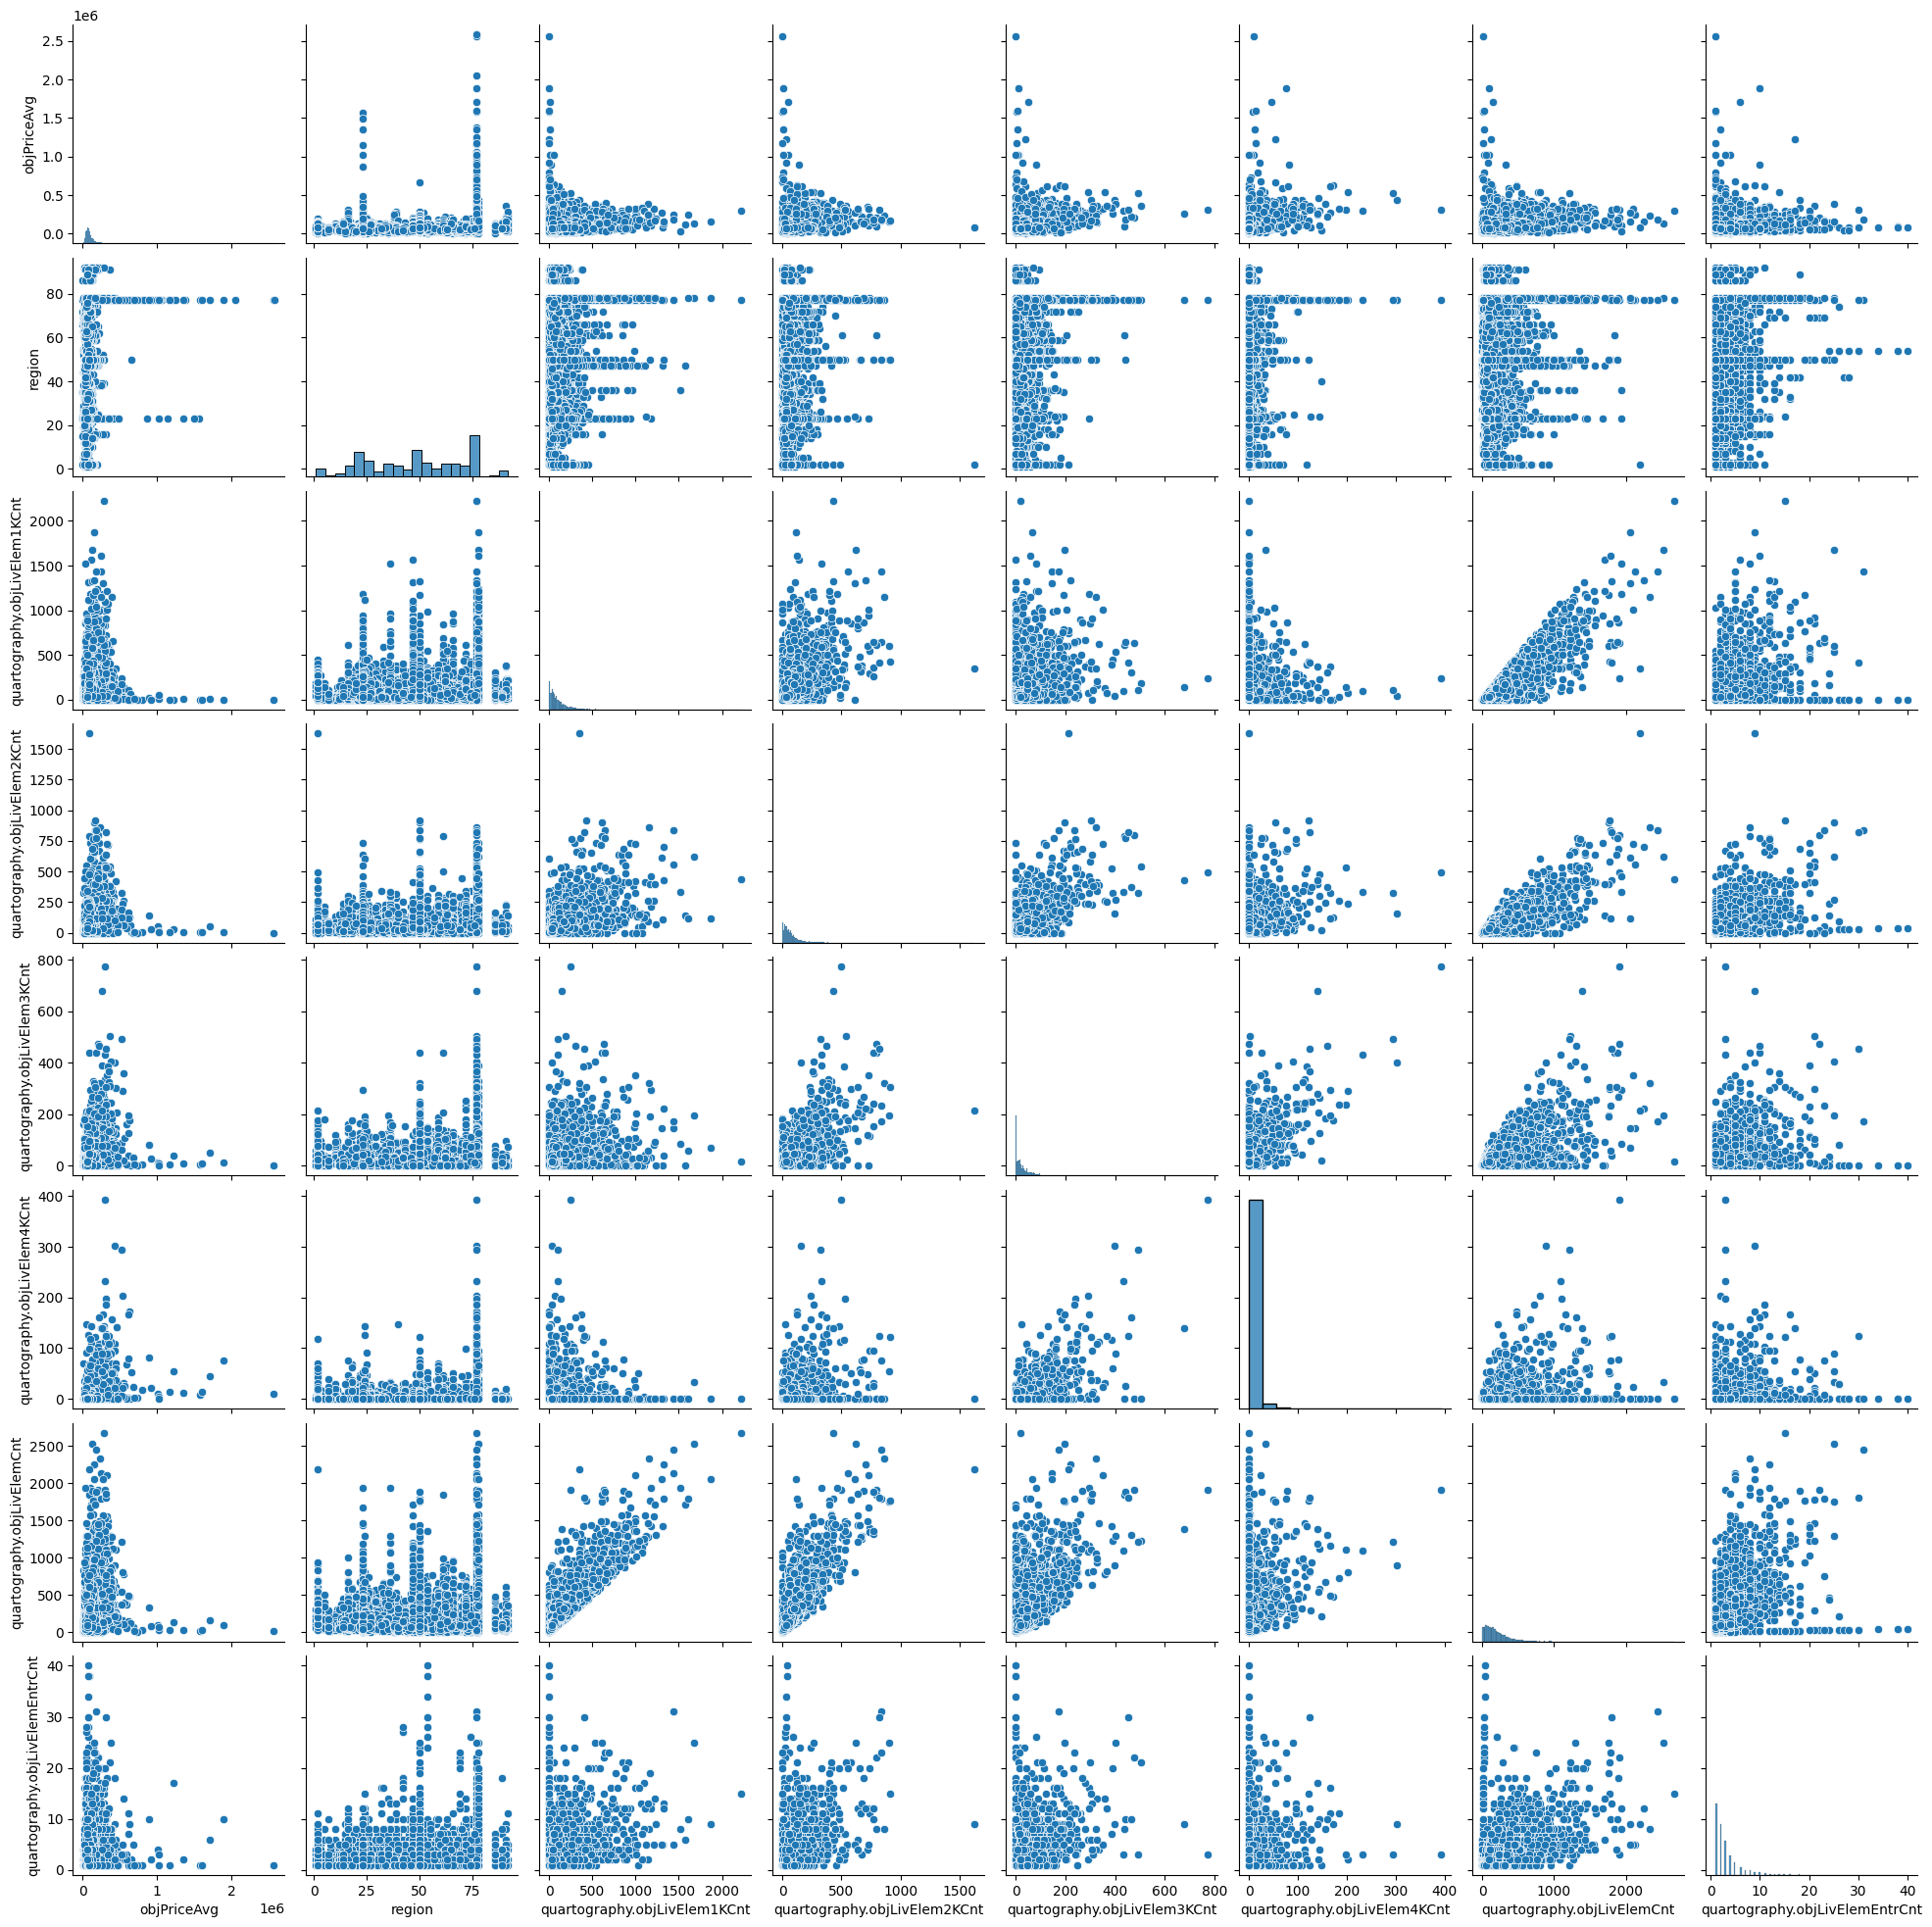

In [112]:
df1 = df.loc[:,['objPriceAvg', 'region', 'address', 'objReady100PercDt', 'objLkClassDesc', 'quartography.objLivElem1KCnt', 'quartography.objLivElem2KCnt', 'quartography.objLivElem3KCnt', 'quartography.objLivElem4KCnt', 'quartography.objLivElemCnt', 'quartography.objLivElemEntrCnt']]
sns.pairplot(
    df1,
 #   hue='Promotion',
#     kind='reg'
)
plt.show();

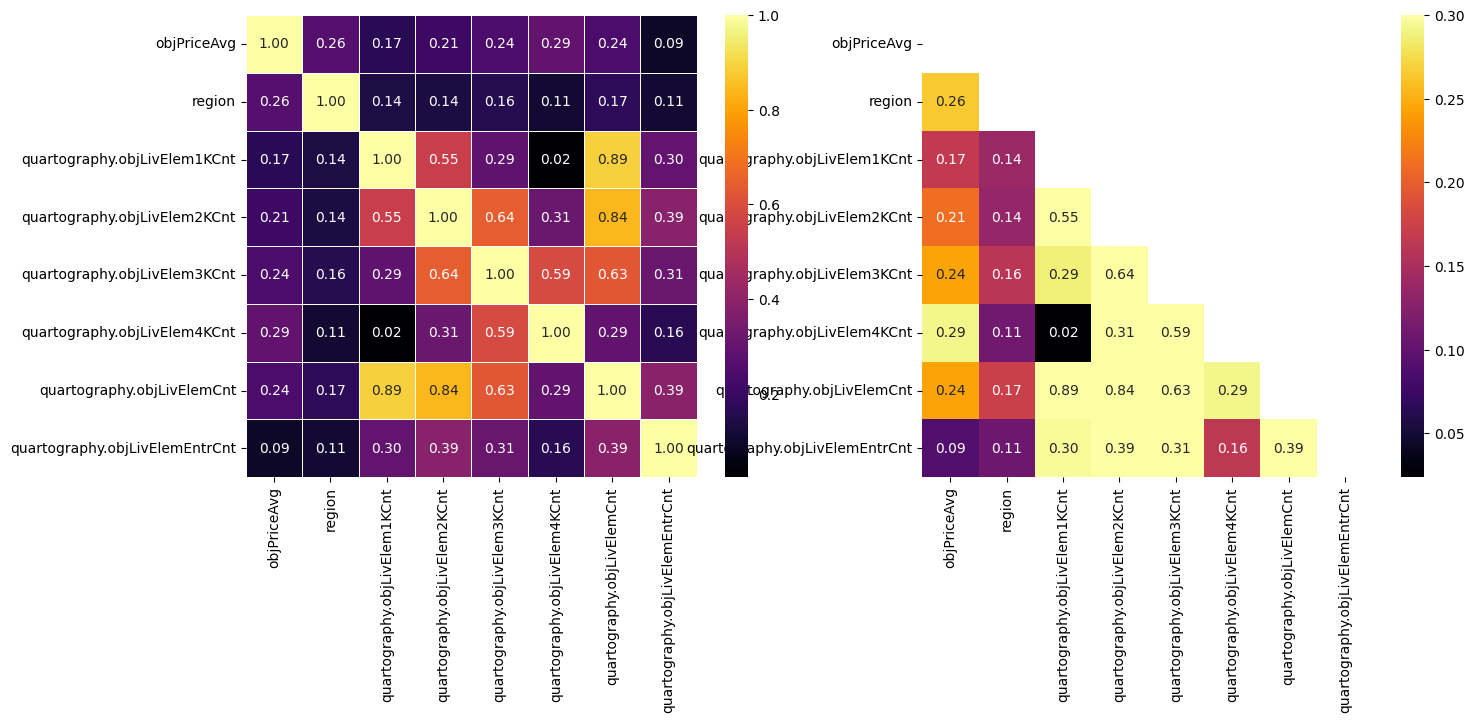

In [114]:
# Формирование матрицы с коэффициентами корреляции
corr = df1.corr()
set(df1.objPriceAvg)
corr

fig, (ax1, ax2)= plt.subplots(1,2, figsize=(16,6)) 
sns.heatmap(corr, annot=True, fmt='.2f',linewidths=.5, cmap="inferno", ax=ax1)

# Удаление верхней части тепловой карты

mask = np.zeros_like(corr)

np.triu_indices_from(mask)
mask[np.triu_indices_from(mask)] = True

mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, vmax=.3, annot=True, fmt='.2f', cmap="inferno", ax=ax2)
plt.show();

In [25]:
df.dropna(how = 'all', axis=1, inplace=True)
df

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,developer.bankruptStage.bankruptStageDesc,developer.bankruptStage.bankruptLawUrl,developer.orgBankruptMsgDttm,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors
0,29679,124647,61,г Таганрог,18,2020-03-31,Другое,Под ключ,Есть,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13399,28141,72,"г Тюмень, ул Профсоюзная, д. 56",0,2024-12-31,Другое,Без отделки,Нет,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13398,28141,72,"г Тюмень, ул Профсоюзная, д. 56",43,2024-12-31,Другое,Без отделки,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10580,28072,96379,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",312,2024-06-30,Другое,Под ключ,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10581,28071,99284,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",288,2024-06-30,Другое,Под ключ,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10582,28073,96446,50,"г Котельники, район мкр.Ковровый, д.1-5, 24-29...",312,2024-06-30,Другое,Под ключ,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10583,44447,475093,76,"г Ярославль, Фрунзенский район, территория в р...",127,2022-12-31,Кирпич,Другое,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
col_nul_sum = df.isnull().sum(axis=0)
col_nul_sum[col_nul_sum.values > 0.9*len(df)]